# 1. Importing the required libraries

In [1]:
# Importing and loading the libraries to this note book
import os                              # os makes it easier to navigate through directories
from matplotlib import pyplot as plt   # used for visualizing results & waveforms
import tensorflow as tf                # build deep learning model
import tensorflow_io as tfio           # process & convert audio clips
import IPython.display as ipd          # used for playing the audio
import warnings                        # ignore all the warnings
warnings.filterwarnings("ignore")

# 2. Building the data loading function & Creating Visualiztaions

In [ ]:
# Loading the data using os
os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing')   # dataset from https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

['Parsed_Not_Capuchinbird_Clips',
 'Forest Recordings',
 'Parsed_Capuchinbird_Clips']

In [ ]:
# Defining Paths for Capuchin Bird & Non-Capuchin Bird Files using os
Capuchin_Bird_File = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')                                  # Capuchin Bird File Path
Non_Capuchin_Bird_File = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')  # Non Capuchin Bird File Path

In [4]:
# Playing the 'Capuchin_Bird_File' audio file to hear capuchin bird call using ipd
ipd.Audio(Capuchin_Bird_File)

In [5]:
# Playung the 'Non_Capuchin_Bird_File' audio file to hear non capuchin bird call using ipd
ipd.Audio(Non_Capuchin_Bird_File)

In [6]:
# This function is for decoding our audio file
def Loading_wav_16k_mono(filename):            # processing the audio file & converting it to 16 hertz & get single channel
    # Loading the encoded wav file
    Content_Files = tf.io.read_file(filename)  # convert the file to a wavform & passing through the file path
    # Decoding WAV using tensors by channels 
    WAV, Rate_Sample = tf.audio.decode_wav(Content_Files, desired_channels=1) # makes it easier to process our audio later on
    # Removing trailing axis using tf.squeeze & tf.cast
    WAV = tf.squeeze(WAV, axis=-1)            # squeezes the wave file and removes -1 axis
    Rate_Sample = tf.cast(Rate_Sample, dtype=tf.int64)  # format for rate sample
    # Allowing the WAV to Go from 44100Hz to 16000hz 
    WAV = tfio.audio.resample(WAV, rate_in=Rate_Sample, rate_out=16000)  # Change the rate sample using rate input & output
    return WAV                                # return wave audio file

In [7]:
# Visualizing the sound wave of capuchin & non capuchin files
cb_wave = Loading_wav_16k_mono(Capuchin_Bird_File)     # Defining cb_wave / capuchin bird wav using the file from the dataset
nb_wave = Loading_wav_16k_mono(Non_Capuchin_Bird_File) # Defining nb_wave / non capuchin bird wav using the file from the dataset

2023-01-13 17:31:28.693665: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-13 17:31:28.816898: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2023-01-13 17:31:28.998687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


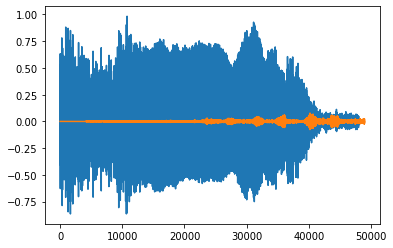

In [8]:
# Creating the plot for visualization using matplotlib
plt.plot(cb_wave) # blue wave for capuchin
plt.plot(nb_wave) # yellow wave for non capuchin
plt.show()        # shows the plot outcome

# 3. Creating Tensorflow Dataset

In [9]:
# Defining paths to positive and Negative Data using os
Positive_Path = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')     # positive path / capuchin bird
Negative_Path = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips') # negative path / non capuchin bird

In [10]:
# Creating the tensorflow Dataset using the list_files method from tensorflow
Positive_dataset = tf.data.Dataset.list_files(Positive_Path+'/*.wav') # positive dataset / capuchin bird
Negative_dataset = tf.data.Dataset.list_files(Negative_Path+'/*.wav') # negative dataset / non capuchin bird

In [11]:
# Adding labels and Combining positive and negative samples using zip from tensorflow
Positive_Samples = tf.data.Dataset.zip((Positive_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(Positive_dataset)))))  # positive sample / capuchin bird call
Negative_Samples = tf.data.Dataset.zip((Negative_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(Negative_dataset))))) # negative sample / non capuchin bird call
# Defining data using the samples 
data = Positive_Samples.concatenate(Negative_Samples)                                                                           

# 4. Determining Average Length of a Capuchin Call

In [12]:
# Creating a loop for calculating the wave cycle length
lengthsArray = []
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):   # gets through the files using os 
    tensor_wave = Loading_wav_16k_mono(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file)) # load the files into a wave format
    lengthsArray.append(len(tensor_wave)) # checks how long each wave are

In [13]:
# Checking the mean of the lengthsArray using reduce_mean from tensorflow
tf.math.reduce_mean(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
# Dividing the mean audio length to rate output to get the mean in seconds
54156/16000

3.38475

In [15]:
# Checking the min of the lengthsArray using reduce_min from tensorflow
tf.math.reduce_min(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
# Dividing the min audio length to rate output to get the min in seconds
32000/16000

2.0

In [17]:
# Checking the max of the lengthsArray using reduce_max from tensorflow
tf.math.reduce_max(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [18]:
# Dividing the max audio length to rate output to get the max in seconds
80000/16000 

5.0

# 5. Using a Preprocessor Function for spectogram convertion

In [19]:
# Building the pre_processor function
def preprocessor(file_path, label): 
    WAV = Loading_wav_16k_mono(file_path)  # loads the data into its waveform
    WAV = WAV[:48000] # taking the first 48000 steps of all signals
    zero_filler = tf.zeros([48000] - tf.shape(WAV), dtype=tf.float32)  # checks if audio length is large, then fill above 48000 steps with 0
    WAV = tf.concat([zero_filler, WAV],0)   # overriding zeros using tf.concat method
    # creating the spectogram
    spectrogram = tf.signal.stft(WAV, frame_length=320, frame_step=32) # short time fourier transform is used for converting the data into spectogram
    spectrogram = tf.abs(spectrogram)  # convert the spectogram into absolute set of values
    spectrogram = tf.expand_dims(spectrogram, axis=2) # ensure that the spectogram is in the appropriate format that we need
    return spectrogram, label  # returns the spectogram, and label

In [20]:
# Testing the pre_processor function and visualizing the spectogram for capuchin bird call
filepath, label = Positive_Samples.shuffle(buffer_size=10000).as_numpy_iterator().next() # numpy iterator() & next() allows us to get the next example out of positive sample data

In [21]:
# Testing the pre_processor function and visualizing the spectogram for capuchin bird call
spectrogram, label = preprocessor(filepath, label) # gets the spectogram & label back

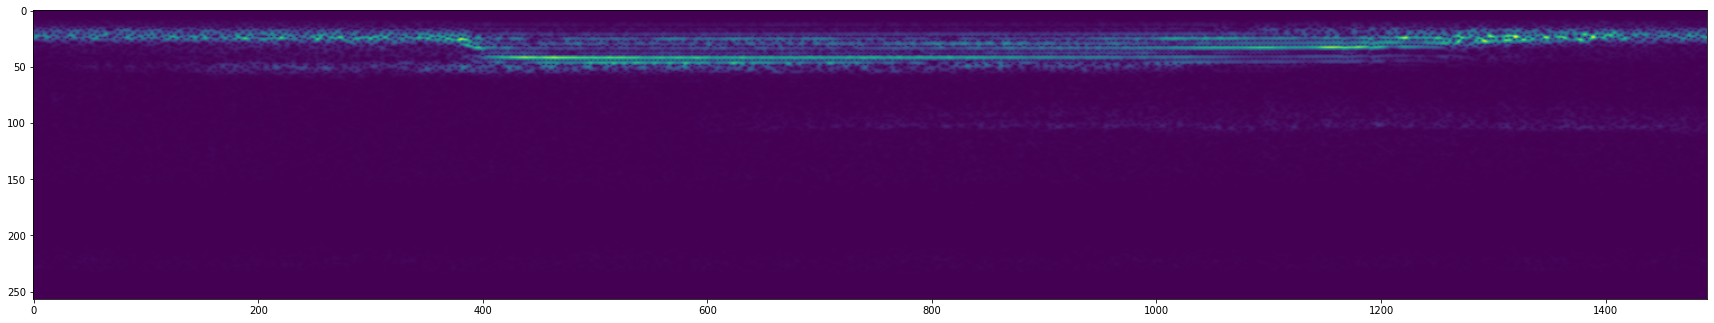

In [22]:
# Visualizing the Positive Data / Capuchin Bird
plt.figure(figsize=(30,20))              # setting the figure size
plt.imshow(tf.transpose(spectrogram)[0]) # setting the spectogram
plt.show()                               # showing the spectogram 

In [23]:
# Testing the pre_processor function and visualizing the spectogram for capuchin bird call
filepath, label = Negative_Samples.shuffle(buffer_size=10000).as_numpy_iterator().next() # numpy iterator() & next() allows us to get the next example out of negative sample data

In [24]:
# Testing the pre_processor function and visualizing the spectogram for non capuchin bird call
spectrogram, label = preprocessor(filepath, label) # gets the spectogram & label back

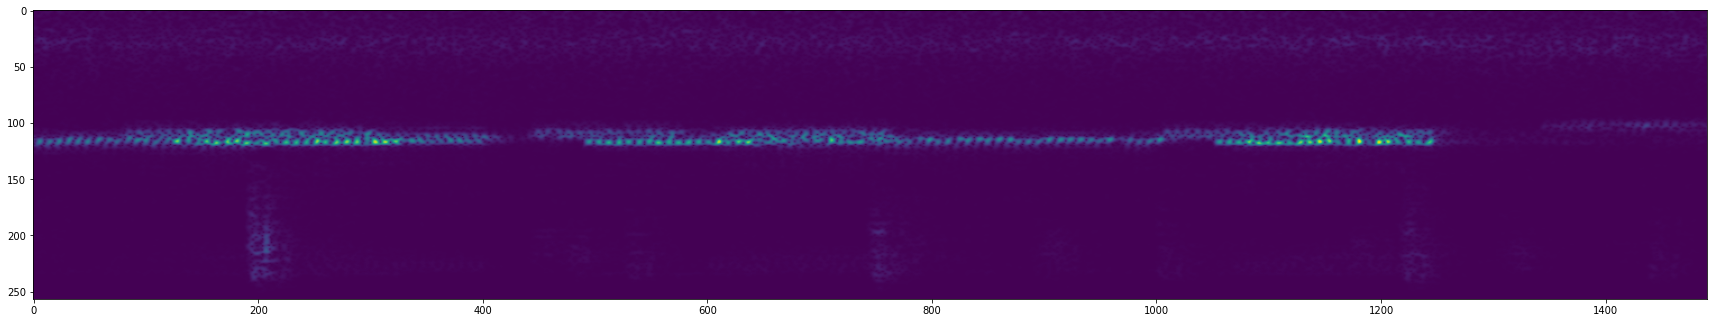

In [25]:
# Visualizing the Negative Data / Non Capuchin Bird
plt.figure(figsize=(30,20))              # setting the figure size
plt.imshow(tf.transpose(spectrogram)[0]) # setting the spectogram
plt.show()                               # showing the spectogram 

# 6. Creating Training and Testing Sets

In [26]:
# Creating a Tensorflow Data Pipeline
data = data.map(preprocessor)         # preprocessing the data on spectrogram method
data = data.cache()                   # cache the data
data = data.shuffle(buffer_size=1000) # shuffling and mix the positive & negative datasets
data = data.batch(16)                 # training on 16 samples at a time
data = data.prefetch(8)               # prefetching 8 examples to eliminate cpu bottlenecking 

In [27]:
# Splitting the data into training and testing sets
train = data.take(36)         # assigning partitions to train
test = data.skip(36).take(15) # skip the 36 and take the last 15 as training sample

In [28]:
# Testing One Batch
samples, labels = train.as_numpy_iterator().next() # numpy iterator() & next() allows us to get the next example out of sample data

2023-01-13 17:31:53.480866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 390 of 1000
2023-01-13 17:32:03.477830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 768 of 1000
2023-01-13 17:32:04.575465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [29]:
# Getting the shape of the samples
samples.shape

(16, 1491, 257, 1)

# 7. Building and Training the Deep Learning Model

In [30]:
# Loading the Tensorflow Libraries to build the sequential model
from tensorflow.keras.models import Sequential             # for building a sequential model
from tensorflow.keras.layers import Conv2D, Dense, Flatten # bring in the required layers

In [31]:
# Building the Sequential Model, Compile and View Summary
sequentialModel = Sequential() # defining the model
sequentialModel.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1))) # matches input shape the spectrogram
sequentialModel.add(Conv2D(16, (3,3), activation='relu')) # com 2d specifies the 16 diff kernels of shape (3x3), activates relative function / rectified linear unit
sequentialModel.add(Flatten()) # flatten down to single dimension
sequentialModel.add(Dense(128, activation='relu')) # dense layer of 128 value & relu activation
sequentialModel.add(Dense(1, activation='sigmoid')) # dense layer of 1 value & sigmoid activation

In [32]:
# Compiling the model
sequentialModel.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy']) # loss and accuracy

In [33]:
# Printing out the model summary
sequentialModel.summary() # using summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Training & fitting the model using 4 epochs 
trainingHistory = sequentialModel.fit(train, epochs=4, validation_data=test) # allows to get the training values

Epoch 1/4
36/36 [==============================] - 96s 3s/step - loss: 3.7850 - accuracy: 0.9010 - val_loss: 0.5285 - val_accuracy: 0.9530
Epoch 2/4
36/36 [==============================] - 94s 3s/step - loss: 0.1332 - accuracy: 0.9844 - val_loss: 0.7261 - val_accuracy: 0.9274
Epoch 3/4
36/36 [==============================] - 93s 3s/step - loss: 0.3119 - accuracy: 0.9722 - val_loss: 0.5389 - val_accuracy: 0.8803
Epoch 4/4
36/36 [==============================] - 93s 3s/step - loss: 0.0852 - accuracy: 0.9878 - val_loss: 0.0535 - val_accuracy: 0.9957


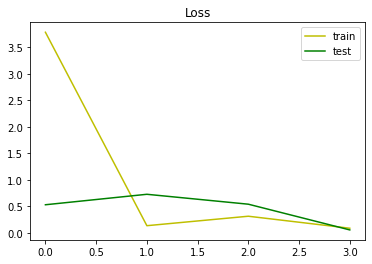

In [35]:
# Printing plot visualization for loss
plt.title('Loss') # plot name
plt.plot(trainingHistory.history['loss'], 'y')  # coloring loss yellow
plt.plot(trainingHistory.history['val_loss'], 'g') # coloring val_loss green
plt.legend(['train', 'test'])  # stating the train & test 
plt.show() # showing the plot outcome

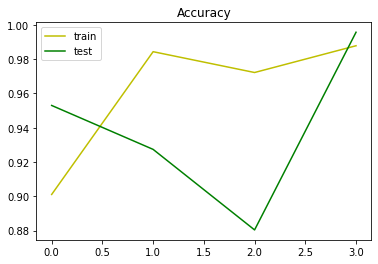

In [36]:
# Printing plot visualization for Accuracy
plt.title('Accuracy') # plot name
plt.plot(trainingHistory.history['accuracy'], 'y') # coloring accuracy yellow
plt.plot(trainingHistory.history['val_accuracy'], 'g') # coloring val_accuracy green
plt.legend(['train', 'test']) # stating the train & test 
plt.show() # showing the plot outcome

In [37]:
# Evaluating the sequentialModel
evaluation = sequentialModel.evaluate(test, verbose=0) 

In [38]:
# Printing the result for Model's loss
print("Model Loss", evaluation[0])

Model Loss 0.03446289151906967


In [39]:
# Printing the result for Model's Accuracy
print("Model Accuracy", evaluation[1])

Model Accuracy 1.0


# 8. Making Prediction on Single Clip

In [40]:
# Gettine one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next() # x - spectogram, y - labels

In [41]:
# Getting the spectogram shape
X_test.shape

(16, 1491, 257, 1)

In [42]:
# Getting the labels shape
y_test.shape

(16,)

In [43]:
# Predicting capuchin bird call
y_hat = sequentialModel.predict(X_test)

**Converting Loggits to classes**

In [44]:
# Prediction format
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat] 

In [45]:
# Printing out the y_hat value
y_hat

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]

In [46]:
# Printing out the y_test value
y_test.astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

# 9. Build Forest Parsing Functions

In [47]:
# This function is for decoding our audio file
def Loading_wav_16k_mono(filename): # loading WAV file
    res = tfio.audio.AudioIOTensor(filename) # converting WAV file to a float tensor
    # Converting WAV to tensor and combining channels 
    tensor = res.to_tensor() # taking the tensor
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 # adding the tensor and dividing it by 2
    # Extracting sample rate and cast
    Rate_Sample = res.rate # defining rate sample
    Rate_Sample = tf.cast(Rate_Sample, dtype=tf.int64) # format for rate sample
    # Resampling WAV to 16 kHz
    WAV = tfio.audio.resample(tensor, rate_in=Rate_Sample, rate_out=16000) # Change the rate sample using rate input & output
    return WAV # returns the WAV

In [48]:
# Loading & Defining up MP3 using os
mp3 = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_08.mp3') # defining the mp3 & getting its variable from the given path

In [49]:
# Giving variable to WAV
WAV = Loading_wav_16k_mono(mp3) # loading the mp3 using the Loading_wav_16k_mono function

In [50]:
# Converting the file into audio slices
slicedAudio = tf.keras.utils.timeseries_dataset_from_array(WAV, WAV, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [51]:
# Slicing audio for samples & index
samples, index = slicedAudio.as_numpy_iterator().next()

In [52]:
# Building the pre_processor function
def preprocessor_mp3(sample, index):
    sample = sample[0] # defining the sample
    zero_filler = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32) # checks if audio length is large, then fill above 48000 steps with 0
    WAV = tf.concat([zero_filler, sample],0) # overriding zeros using tf.concat method
    spectrogram = tf.signal.stft(WAV, frame_length=320, frame_step=32) # short time fourier transform is used for converting the data into spectogram
    spectrogram = tf.abs(spectrogram) # convert the spectogram into absolute set of values
    spectrogram = tf.expand_dims(spectrogram, axis=2) # ensure that the spectogram is in the appropriate format that we need
    return spectrogram # returns the spectogram

In [53]:
# Convert audi slices into spectograms
slicedAudio = tf.keras.utils.timeseries_dataset_from_array(WAV, WAV, sequence_length=16000, sequence_stride=16000, batch_size=1) # using tensorflow
slicedAudio = slicedAudio.map(preprocessor_mp3) # using map
slicedAudio = slicedAudio.batch(64) # using batch

In [54]:
# Making Predictions
y_hat = sequentialModel.predict(slicedAudio) # predicting the model using the slicedAudio
y_hat = [1 if prediction > 0.99 else 0 for prediction in y_hat] # prediction format

**Group Consecutive Detections**

In [55]:
# Importing groupby method
from itertools import groupby # allows to treat consecutive callls as single call

In [56]:
# Grouping the predicted value 
y_hat = [key for key, group in groupby(y_hat)] # grouping format for prediction
calls = tf.math.reduce_sum(y_hat).numpy() # defining calls using this formula

In [57]:
# prints out the number of calls
calls

25

In [58]:
# Playing the mp3 file using ipd
ipd.Audio(mp3) # playing the audio mp3 

# 10. Making Capuchin Bird Call Predictions for the whole dataset

In [59]:
# Looping the over all recordings and make predictions
results = {}
for file in os.listdir(os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')): # looping through every single recording from forest recordings
    FILEPATH = os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file) # defining file path
    # WAV file & slicedAudio
    WAV = Loading_wav_16k_mono(FILEPATH) # each recording will be loaded on the given path
    slicedAudio = tf.keras.utils.timeseries_dataset_from_array(WAV, WAV, sequence_length=48000, sequence_stride=48000, batch_size=1) # convert tinto audio slices
    slicedAudio = slicedAudio.map(preprocessor_mp3) # converting into spectogram
    slicedAudio = slicedAudio.batch(64) # batch it up
    # defining predicted value
    y_hat = sequentialModel.predict(slicedAudio) # start predicting
    # defining the results 
    results[file] = y_hat # stores the predictions into results files

In [60]:
# Making the class prediction 
classPrediction = {}
for file, logits in results.items(): # loop through every results 
    classPrediction[file] = [1 if prediction > 0.99 else 0 for prediction in logits] # convert to classPrediction
classPrediction # show classPredictions

{'recording_76.mp3': [1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [61]:
# Convert Predictions into Classes to identify which recording has a capuchin bird call with it
postprocessedPrediction = {}
for file, scores in classPrediction.items(): # loop through every classPredictions
    postprocessedPrediction[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy() # gets the next file
postprocessedPrediction # convert & shows the postprocessedPrediction

{'recording_76.mp3': 6,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 4,
 'recording_06.mp3': 8,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 2,
 'recording_65.mp3': 5,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 4,
 'recording_64.mp3': 3,
 'recording_39.mp3': 1,
 'recording_04.mp3': 7,
 'recording_28.mp3': 2,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 4,
 'recording_12.mp3': 6,
 'recording_59.mp3': 2,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 2,
 'recording_86.mp3': 2,
 'recording_47.mp3': 2,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 20,
 'recording_51.mp3': 4,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_46.